# libraries

In [2]:
import Backtest.backtest as bb
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, date, timedelta, timezone
import pandas as pd
import Backtest.account as acc
import numpy as np
import random
import warnings
warnings.simplefilter('ignore')
import pandas_ta as ta
from scipy.stats import linregress

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings

from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from hmmlearn.hmm import GaussianHMM

import warnings
warnings.filterwarnings("ignore")

import pywt
from scipy.stats import entropy
from scipy.signal import hilbert

def log_ret(s):                # daily log-return
    return np.log(s/ s.shift(1))


def compute_time_series_momentum(prices: pd.Series, lookback: int = 252) -> pd.Series:
    """
    Compute time-series momentum signals for a pandas Series of prices.
    Returns +1 when trailing return > 0, and -1 otherwise.
    """
    # Compute trailing return over 'lookback' periods
    momentum = prices.pct_change(periods=lookback)
    # Generate signal: +1 for long, -1 for short (or 0 to flatten)
    signal = np.where(momentum > 0, 1.0, -1.0)
    return pd.Series(signal, index=prices.index)

# Example usage:
# prices = pd.Series([...])  # daily or weekly prices
# signal = compute_time_series_momentum(prices, lookback=252)

def RSI(data):
    
    delta = data.close_price.diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the average gain and loss
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()

    # Calculate the Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))
    rsi.loc[rsi.isna()] = 0
    
    return(rsi)

def stoch_osc_k(data, n = 14):
    data['LowestLow']  = data['low_price'].rolling(window=n).min()
    data['HighestHigh'] = data['high_price'].rolling(window=n).max()
    data['%K'] = 100 * (data.close_price - data['LowestLow']) / (data['HighestHigh'] - data['LowestLow'])
    
    data['%K'].loc[data['%K'].isna()] = 0
    return(data['%K'])

def stoch_osc_d(data, n = 14):
    data['LowestLow']  = data['low_price'].rolling(window=n).min()
    data['HighestHigh'] = data['high_price'].rolling(window=n).max()
    data['%K'] = 100 * (data.close_price - data['LowestLow']) / (data['HighestHigh'] - data['LowestLow'])
    data['%D'] = data['%K'].rolling(window=3).mean()
    
    data['%K'].loc[data['%K'].isna()] = 0
    data['%D'].loc[data['%D'].isna()] = 0
    return(data['%D'])

In [129]:
def _strat(data):
    
    signal = []

    for i in range(len(data)):
        
        if np.sum(data['PN_counter'][i-100:i]) > 5:
            signal.append(["aa",0.004])
            
        elif np.sum(data['PN_counter'][i-100:i]) > 0 and np.sum(data['PN_counter'][i-100:i]) < 2:
            signal.append(["a",0.004])
            
        elif np.sum(data['PN_counter'][i-100:i]) < 0 and np.sum(data['PN_counter'][i-100:i]) > -1:
            signal.append(["b",0.004])
            
        elif np.sum(data['PN_counter'][i-100:i]) < -1 and np.sum(data['PN_counter'][i-100:i]) > -2:
            signal.append(["c",0.004])

        elif np.sum(data['PN_counter'][i-100:i]) < -2:
            signal.append(["cc",0.004])

        else:
            signal.append(["",0])  
    
    signal = pd.DataFrame(signal, columns = ["strategy", "Position"])
    
    return(signal)

a = _strat(data)
strat_plot(data, a)

KeyError: 'PN_counter'

In [ ]:
def strat_plot(data, strat):
    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))

    # Price plot
    ax1.set_facecolor('dimgrey')
    ax1.plot(data.index, data['Close'], linewidth = 2, color = "white")

    long_signal_dates = strat[strat['strategy'] == "buy"].index
    for date in long_signal_dates:
        ax1.annotate('x', xy=(date, data.iloc[date, 3]), color='lime', fontsize=14, ha='center')

    long_signal_dates = strat[strat['strategy'] == "sell"].index
    for date in long_signal_dates:
        ax1.annotate('x', xy=(date, data.iloc[date, 3]), color='red', fontsize=14, ha='center')
    
    plt.grid()
    plt.show()

# Data

In [ ]:
from kraken.spot import SpotClient

client = SpotClient(key="wwNo7XJL0OmK+iUpCUURdQakcohPuEwSYHMjLmqvtoKa2t2HG8qh4zIK", secret="murQoy7j9EUtGYDDwEY4KTl5f0nQdOer+bwdwm8Ybn2gsR44ol1nIV0cco5+xK5dcMfU4QCHmR5ea3LAE5ucVA==")
print(client.request("POST", "/0/private/Balance"))

In [4]:
from __future__ import annotations
import asyncio, time, datetime as dt, json, math, aiohttp, websockets
import pandas as pd
import requests

import binance
import binance.spot
import pandas as pd


def to_ms(ts: dt.datetime) -> int:
    "Convert naïve/UTC dt -> Unix epoch ms"
    return int(ts.replace(tzinfo=dt.timezone.utc).timestamp() * 1000)


class data:
    
    def __init__(self):
        
        api_key = 'vBrHMZUCDxlfNiAreBj02aUrymSFMGyl1AwJNAP0O7qVlvh07Drq7qQwfQlbYGeS'
        api_secret = 'SdzCkiFE5zNjkSvptRVpxQBxlUWZWYrjnRGLp5tzhzJiat79vymOH127zaKHnnCh'
        self.client = binance.spot.Spot(api_key, api_secret)
        self.data = pd.DataFrame()


    def fetch_binance_data(self, symbol = "BTCUSDC"):
        
        for i in range(48):
            start = int(1753176882000 - (i+1) * 1000000)
            end = int(1753176882000 - (i) * 1000000)
            data = pd.DataFrame(self.client.klines(symbol, interval = "1s", startTime = start, endTime = end, limit = 1000))

            data.columns = ["open_time", "open_price", "high_price","low_price","close_price", "volume", "close_time", "quote_asset_volume", "number_of_trades", "Taker_buy_base_asset_volume", "Taker_buy_quote_asset_volume", "unused"]

            data.open_price = data.open_price.astype(float)
            data.high_price = data.high_price.astype(float)
            data.low_price = data.low_price.astype(float)
            data.close_price = data.close_price.astype(float)
            data.volume = data.volume.astype(float)
            data.quote_asset_volume = data.quote_asset_volume.astype(float)
            data.number_of_trades = data.number_of_trades.astype(float)
            data.Taker_buy_base_asset_volume = data.Taker_buy_base_asset_volume.astype(float)
            data.Taker_buy_quote_asset_volume = data.Taker_buy_quote_asset_volume.astype(float)

            self._data = data[["open_price", "high_price","low_price","close_price", "volume", "quote_asset_volume", "number_of_trades", "Taker_buy_base_asset_volume", "Taker_buy_quote_asset_volume"]]
            
            self.data = pd.concat([self.data, self._data])
        self.data = self.data.reset_index(drop = True)
            
            
            
def fetch_deribit_candles(instrument: str,start: dt.datetime,end: dt.datetime, resolution: str = "1") -> pd.DataFrame:

    ONE_MIN   = 60_000               # ms
    out = []
    start_ms, end_ms = to_ms(start), to_ms(end)

    # Chunk the range so max 1500 bars/request
    step = ONE_MIN * 1_500

    for chunk_start in range(start_ms, end_ms, step):

        chunk_end = min(chunk_start + step, end_ms)

        params = dict(instrument_name = instrument, start_timestamp=chunk_start, end_timestamp=chunk_end, resolution=resolution)
        url = f"https://www.deribit.com/api/v2/public/get_tradingview_chart_data"
        r   = requests.get(url, params=params, timeout=10).json()

        if r["result"]["status"] != "ok":
            raise RuntimeError(r)

        res = r["result"]
        out.append(pd.DataFrame({"open":res["open"], "high":res["high"],"low": res["low"],"close" : res["close"], "volume": res["volume"], "ts": res["ticks"],}))

        # polite pacing – public rate‑limit is 20 req / 2 s
        time.sleep(0.12)

    if not out:
        return pd.DataFrame()

    df = pd.concat(out, ignore_index=True)
    df["ts"] = pd.to_datetime(df["ts"], unit="ms", utc=True)
    df = df.set_index("ts").sort_index()
    return df
            
            

In [5]:
bd = data()
bd.fetch_binance_data("BTCUSDC")
bd.data

#bd.data.to_csv('BTCUSDC.csv', index=False)

,open_price,high_price,low_price,close_price,volume,quote_asset_volume,number_of_trades,Taker_buy_base_asset_volume,Taker_buy_quote_asset_volume
0,117932.56,117932.56,117932.56,117932.56,0.00200,235.865120,1.0,0.00000,0.000000
1,117932.56,117932.56,117932.56,117932.56,0.00000,0.000000,0.0,0.00000,0.000000
2,117932.73,117932.73,117932.73,117932.73,0.00081,95.525511,1.0,0.00000,0.000000
3,117932.74,117932.74,117932.74,117932.74,0.03680,4339.924832,2.0,0.03680,4339.924832
4,117936.00,117936.00,117936.00,117936.00,0.00014,16.511040,1.0,0.00014,16.511040
...,...,...,...,...,...,...,...,...,...
47995,117164.84,117164.84,117164.84,117164.84,0.00000,0.000000,0.0,0.00000,0.000000
47996,117164.84,117164.84,117164.84,117164.84,0.00000,0.000000,0.0,0.00000,0.000000
47997,117164.84,117164.84,117164.84,117164.84,0.29540,34610.493736,19.0,0.29540,34610.493736
47998,117164.84,117170.70,117164.84,117170.70,1.01986,119491.850102,9.0,1.01986,119491.850102


In [ ]:
parent_df_calls = []
lst_names_calls = []

parent_df_puts = []
lst_names_puts = []


if __name__ == "__main__":
    # --- pull the last 12 h of minute candles for a Call & Put --- #
    end   = dt.datetime.utcnow()
    start = end - dt.timedelta(hours=12)
    
    stem = "BTC-08AUG25-"
    
    for i in ["104","105","106","107","108","109","110","111","112","113","114","115","116","117","118","119","120","121","122","123","124","125"]:
        
        _id = str(stem+i)
        
        call = stem+i+"000-C"
        put  = stem+i+"000-P"

        lst_names_calls.append(call)
        lst_names_puts.append(put)
        
        df_call = fetch_deribit_candles(call, start, end)
        df_put  = fetch_deribit_candles(put,  start, end)

        parent_df_calls.append(df_call)
        parent_df_puts.append(df_put)

df_calls = pd.DataFrame({
    'Name': lst_names_calls,
    'Data': parent_df_calls
})

df_puts = pd.DataFrame({
    'Name': lst_names_puts,
    'Data': parent_df_puts
})

#df_calls.to_csv("BTC_Call_options.csv")
#df_puts.to_csv("BTC_Put_options.csv")

In [16]:
#import IT.TMRW as TM

data = yf.Ticker("MSFT")
data = data.history(start = "1996-01-01", end = "2025-08-15")
data = data.reset_index(drop = True)

## Features

In [17]:
# returns
data['returns'] = data['Close'].diff()/data['Close'].shift(1)
data['returns'].loc[data['returns'].isna()] = 0

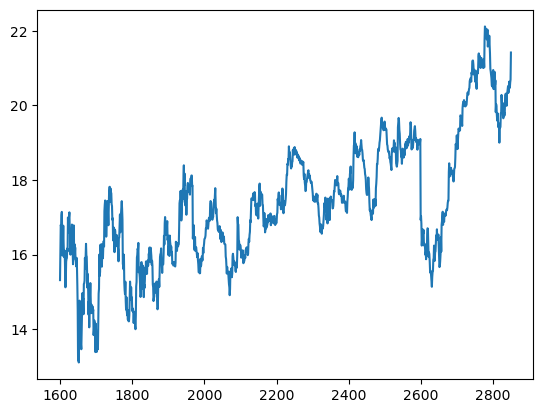

In [68]:
plt.plot(data.index[1600:2850],data.Close[1600:2850])

In [69]:
from scipy.stats import linregress

# Example data
x = list(data.index[1600:2845])
y = list(data.Close[1600:2845])

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Results
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)

Slope: 0.003659253650670713
Intercept: 9.228991542893842
R-squared: 0.5939070151432891


In [12]:
pos_neg = []
for j in range(len(data)):
    if data['returns'][j] >= 0:
        pos_neg.append(1)
    elif data['returns'][j] < 0:
        pos_neg.append(-1)
    else:
        pos_neg.append(0)
data['PN_counter'] = pos_neg

In [13]:
pn_lst = []
for i in range(250):
    lst = []
    
    for j in range(i, len(data)):
        lst.append(np.mean(data["PN_counter"][j-i:j]))
    
    pn_lst.append(np.mean(lst))

In [133]:


# log transform of returns
#data['log returns'] = log_ret(data['Close'])

# acceleration
data['acc'] = data.returns.diff()/data.returns.shift(1)
data['acc'].loc[data['acc'].isna()] = 0
data['acc'][np.isinf(data['acc'])] = 0

# smoothed acceleration
data['acc6'] = data.acc.rolling(window=6).mean()
data['acc20'] = data.acc.rolling(window=20).mean()
data['acc40']= data.acc.rolling(window=40).mean()

# smoothed price
data['ma6'] = data['Close'].rolling(window=6).mean()
data['ma20'] = data['Close'].rolling(window=20).mean()
data['ma40']= data['Close'].rolling(window=40).mean()
data['ma120'] = data['Close'].rolling(window=120).mean()

# Compute MACD line and Signal line
data['EWM_short'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EWM_long']  = data['Close'].ewm(span=64, adjust=False).mean()
data['MACD'] = data['EWM_short'] - data['EWM_long']
data['MACD_Signal'] = data['MACD'].ewm(span=64, adjust=False).mean()

# ITR - interday true range

data['ITR'] = (data['High'] - data['Low']) / (data['Open'])
data['ITR'].loc[data['ITR'].isna()] = 0
data['ITR'][np.isinf(data['ITR'])] = 0

# RSI - relative strength index
data['RSI'] = TM.rsi(data['Close'])
data['RSI'].loc[data['RSI'].isna()] = 0
data['RSI'][np.isinf(data['RSI'])] = 0

# ROC - rate of change
n = 24  # e.g. 24-hour lookback
data['ROC'] = (data.Close - data.Close.shift(n)) / data.Close.shift(n) * 100
data['ROC'].loc[data['ROC'].isna()] = 0
data['ROC'][np.isinf(data['ROC'])] = 0

# timeseries momentum
data['t-momentum'] = compute_time_series_momentum(data['Close'])
data['velocity'] = data['Close'].diff()
data['KineticMomentum'] = 0.5 * np.log(data['Volume']) * (data['returns']**2)
n = 12  # 12-hour momentum
data['MomentumSignal'] = np.sign(data.Close/ data.Close.shift(n) - 1)

n = 24
data['volatility'] = data['returns'].rolling(window=n).std()
data['VolAdjMomentum'] = data['returns'] / data['volatility']

data = data.fillna(0)





UD3 = ["","","","",""]
UD5 = ["","","","",""]
for j in range(5,len(data)):
    string = ""
    for k in range(5):
        if data['PN_counter'][j-(5-k)] == 1:
            string = string + "U"
        elif data['PN_counter'][j-(5-k)] == -1:
            string = string + "D"

    if j > 2:
        UD3.append(string[2:5])

    if j > 4:
        UD5.append(string)

data['UD3'] = UD3
data['UD5'] = UD5

In [143]:
i = 0


0

In [158]:
lst = [0,0]
for i in range(2,len(data)):
    X = np.array(list(data.index[max(i-200,0):i]))
    Y = np.array(list(data.Close[max(i-200,0):i]))
    
    slope, intercept, rvalue, pvalue, stderr = linregress(X,Y)
    
    lst.append(slope)

lst2 = []
for i in range(len(data)):
    lst2.append(data.Close[i] - i * lst[i] - data.Close[0])

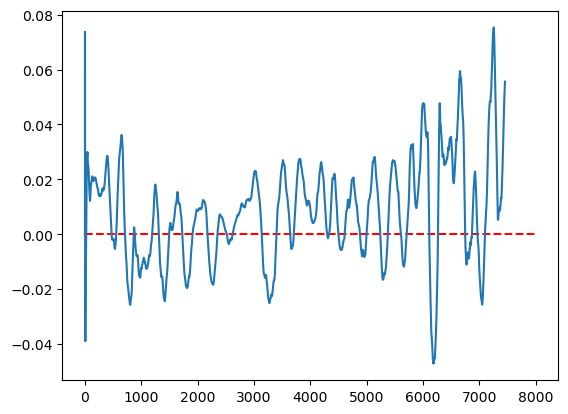

In [160]:

plt.hlines(y=0, xmin=0, xmax=8000, colors='red', linestyles='dashed', label='Horizontal Line')
plt.plot(lst)
#plt.plot(data.returns)

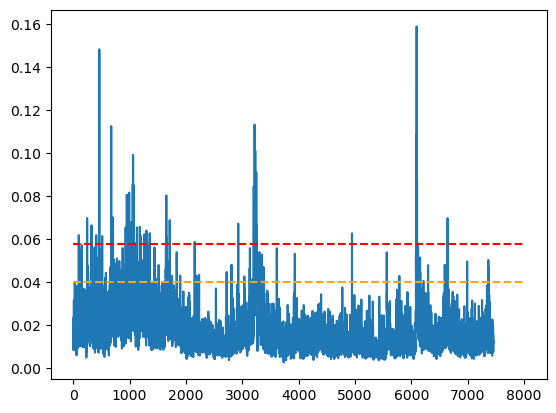

In [113]:
plt.plot(data['ITR'])
plt.hlines(y=0.0575, xmin=0, xmax=8000, colors='red', linestyles='dashed', label='Horizontal Line')
plt.hlines(y=0.04, xmin=0, xmax=8000, colors='orange', linestyles='dashed', label='Horizontal Line')

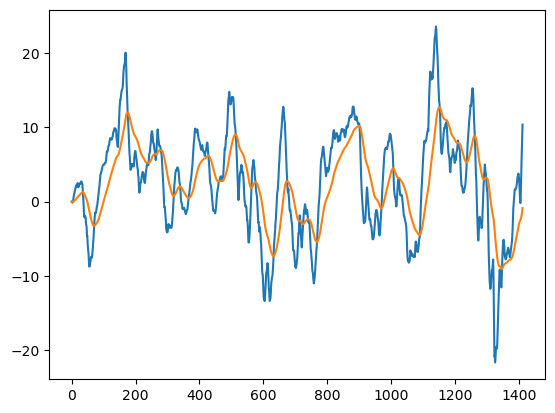

In [191]:

plt.plot(data['MACD'])
plt.plot(data['MACD_Signal'])
#plt.hlines(y=8, xmin=0, xmax=1500, colors='red', linestyles='dashed', label='Horizontal Line')
#plt.hlines(y=-6, xmin=0, xmax=1500, colors='red', linestyles='dashed', label='Horizontal Line')

In [165]:
lst1 = []
lst2 = []

top = []
bottom = []

for i in range(len(data)):
    lst1.append(np.mean(data.acc[i-100:i]) + np.std(data.acc[i-100:i]))
    lst2.append(np.mean(data.acc[i-100:i]) - np.std(data.acc[i-100:i]))
    
    top.append(np.mean(data['RSI'][i-100:i]) + np.std(data['RSI'][i-100:i]))
    bottom.append(np.mean(data['RSI'][i-100:i]) - np.std(data['RSI'][i-100:i]))

In [119]:
np.std(data.Volume)++2*np.mean(data.Volume)

34924060.29371504

13773249.83901261

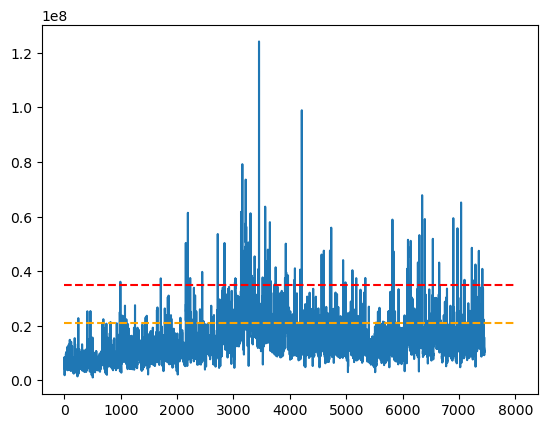

In [120]:
plt.plot(data.Volume)
plt.hlines(y=35000000, xmin=0, xmax=8000, colors='red', linestyles='dashed', label='Horizontal Line')
plt.hlines(y=21150810, xmin=0, xmax=8000, colors='orange', linestyles='dashed', label='Horizontal Line')

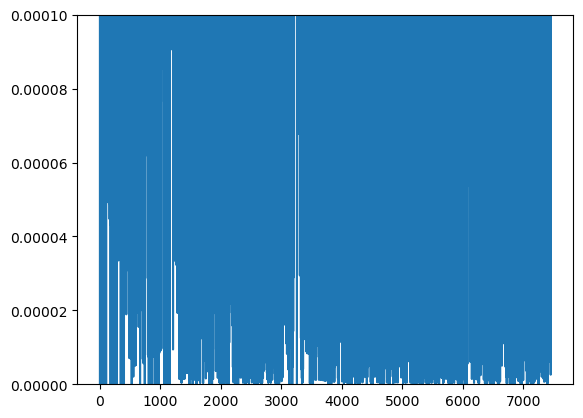

In [105]:
plt.plot(data.KineticMomentum)
#plt.plot(lst1, color = "red")
#plt.plot(lst2, color = "red")
#plt.plot(data.acc, alpha = 0.5)
plt.ylim(0,0.0001)
plt.hlines(y=0.06, xmin=0, xmax=1500, colors='red', linestyles='dashed', label='Horizontal Line')
plt.hlines(y=0.1, xmin=0, xmax=1500, colors='red', linestyles='dashed', label='Horizontal Line')


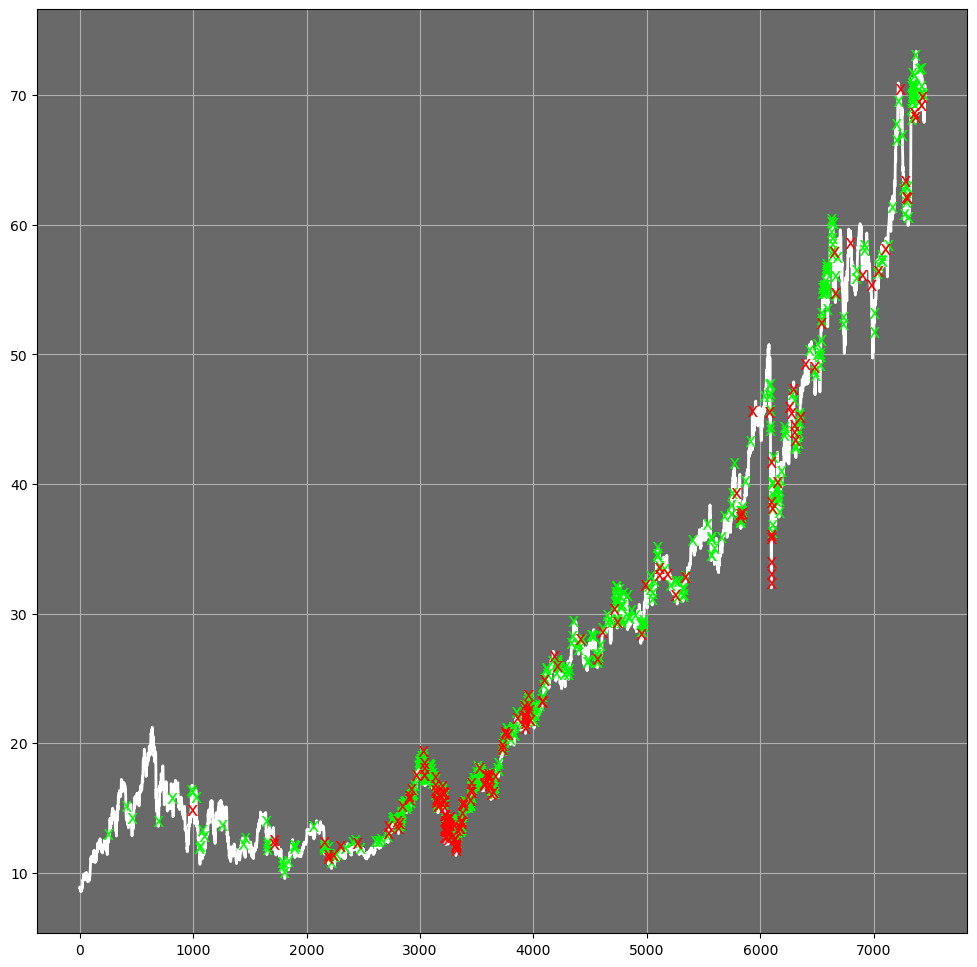

In [126]:
def _strat(data):
    
    signal = []

    for i in range(len(data)):
        
        # down or bottom signals
        
        #if data['RSI'][i] < bottom[i]:
        #if data['acc'][i] < lst1[i]:
        #if data['ROC'][i] < -6:
        #if data['MACD'][i] < data['MACD_Signal'][i]:
        #if data['ITR'][i] > 0.04 and data['ITR'][i] < 0.0575:
        
        
        #if data['ITR'][i] > 0.04 and data['returns'][i] < 0:
        
        #if i > 100 and data['High'][i] >= 1.02 * max(data['High'][i-100:i-1]):
        
        #if lst2[i] < 0:
        #if data.KineticMomentum[i] < 0.000001:
        if data.Volume[i] > np.mean(data.Volume) + 2.5 * np.std(data.Volume):
            signal.append(["sell",0.25])
            #else:
                #signal.append(["",0]) 
        
        # up or top signals
        
        #elif data['RSI'][i] > top[i]:
        #if data['acc'][i] > lst2[i]:
        #elif data['ROC'][i] > 8:
        #elif data['MACD'][i] > data['MACD_Signal'][i]:
        #elif data['ITR'][i] > 0.0575:
        
        
        #elif data['ITR'][i] > 0.04 and data['returns'][i] > 0:
        
        #elif i > 100 and data['Low'][i] <= 0.985 * min(data['Low'][i-50:i-1]):
        #elif lst2[i] > 0:
        #elif data.KineticMomentum[i] > 0.05:
        elif (data.Volume[i] > np.mean(data.Volume) + np.std(data.Volume)) and (data.Volume[i] < np.mean(data.Volume) + 2 * np.std(data.Volume)):
            signal.append(["buy",0.25])
            #else:
                #signal.append(["",0]) 
        else:
            signal.append(["",0])  
    
    signal = pd.DataFrame(signal, columns = ["strategy", "Position"])
    
    return(signal)

a = _strat(data)
strat_plot(data, a)

In [124]:
pnl = 0
val = 10000
value = []
inv = []
_inv = 0

for i in range(len(data)-1):
    
    post = a["Position"][i] 
    
    if a["strategy"][i] == "buy":
        
        pos = val / data['Open'][i+1]
        val = val - pos * post * 1.01 * data['Open'][i+1]
        
        if val > 0:
            _inv = _inv +  post * 1.01 * pos
        else:
            _inv = _inv
        
    if a["strategy"][i] == "sell":
        
        if _inv > 0:
            val = val + _inv * post * 0.99 * data['Open'][i+1]
            _inv = _inv - post * _inv
        else:
            val = val
            _inv = _inv
    
    inv.append(_inv)
    value.append(val)
            

        

val = val + _inv * 0.99 * data['Open'][i]
_inv = 0
print(val / 10000)
print((data['Close'][len(data)-1] - data['Close'][0]) / data['Close'][0])
np.sum(abs(data['returns']))

5.083813333935117
6.8627511863915585


69.33179664151741

# Volatility

In [ ]:
# ???
#avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
#avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()

# Stoch OSC
data['%K'] = stoch_osc_k(data)
data['%D'] = stoch_osc_d(data)



# order-pressure 1
lst = [0]
for i in range(1,len(data)):
    if (data['Taker_buy_base_asset_volume'][i])/ data['volume'][i] >= 0.5:
        lst.append(1)
    else:
        lst.append(0)

data['order pressure'] = lst
data['order pressure'].loc[data['order pressure'].isna()] = 0

# order-pressure distribution
lst = [0]
for i in range(1,len(data)):
    ret_buy = (data['low_price'][i] - data['close_price'][i-1]) / data['close_price'][i-1]
    ret_sell = (data['high_price'][i] - data['close_price'][i-1]) / data['close_price'][i-1]
    buy_press = (data['Taker_buy_base_asset_volume'][i])/ data['volume'][i]
    sell_press = (data['volume'][i] - data['Taker_buy_base_asset_volume'][i])/data['volume'][i]
    
    lst.append(ret_buy * buy_press + ret_sell * sell_press)
    
data['order-pressure distribution'] = lst
data['order-pressure distribution'].loc[data['order-pressure distribution'].isna()] = 0



# ARIMA forecast of price




#

    
## wavelet
coeffs = pywt.wavedec(data['close_price'], 'db4', level=4)   # decompose
# Zero out the smallest-scale detail coefficients (index -1 or -2)
coeffs_filtered = coeffs[:-2] + [None]*2
trend = pywt.waverec(coeffs_filtered, 'db4')
data['WaveletTrend'] = trend[6:]

## HilbertPhase
analytic = hilbert(data['close_price'])
data['HilbertPhase'] = np.unwrap(np.angle(analytic))



up_move = df['high'].diff()
down_move = -df['low'].diff()
plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0)
tr = TrueRange(high, low, close)  # classic ATR’s True Range
plus_di = 100 * ema(plus_dm, period) / ema(tr, period)
minus_di = 100 * ema(minus_dm, period) / ema(tr, period)
dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)
df['ADX'] = ema(dx, period)

# OBV
#df['OBV'] = 0
#for i in range(1, len(df)):
    #if df['close'].iloc[i] > df['close'].iloc[i-1]:
        #df['OBV'].iloc[i] = df['OBV'].iloc[i-1] + df['volume'].iloc[i]
    #elif df['close'].iloc[i] < df['close'].iloc[i-1]:
        #df['OBV'].iloc[i] = df['OBV'].iloc[i-1] - df['volume'].iloc[i]
    #else:
        #df['OBV'].iloc[i] = df['OBV'].iloc[i-1]



## COG, useful version of MA
n = 20
prices = data['close_price']
weights = np.arange(1, n+1)
data['COG'] = (prices.rolling(n).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True))
data['COG'].loc[data['COG'].isna()] = 0

lst = []

for i in range(len(data)):
    mom = 0
    
    #MA indicators
    if ((data.close_price[i] > data.ma40[i]) & (data.close_price[i] > data.ma120[i])).astype(int) == 1:
        mom = mom + 1
    
    elif ((data.close_price[i] < data.ma40[i]) & (data.close_price[i] < data.ma120[i])).astype(int) == 1:
        mom = mom - 1
    
    #MACD
    if (data.MACD[i] > data.Signal[i]).astype(int) == 1:
        mom = mom + 1
    elif (data.MACD[i] < data.Signal[i]).astype(int) == 1:
        mom = mom - 1
    
    # RSI
    if (data['RSI'][i] < 30).astype(int) == 1:
        mom = mom + 1
    
    elif (data['RSI'][i] > 70).astype(int) == 1:
        mom = mom - 1
    
    # Stoch osc
    if ((data['%D'][i] > 80) & (abs(data['%D'][i] - data['%K'][i]) < 30)).astype(int) == 1:
        mom = mom + 1
    elif ((data['%D'][i] < 20) & (abs(data['%D'][i] - data['%K'][i]) < 30)).astype(int) == 1:
        mom = mom - 1
        
    # ROC
    if (data['ROC'][i] > 2.5).astype(int) == 1:
        mom = mom + 1
    
    elif (data['ROC'][i] < -2.5).astype(int) == 1:
        mom = mom - 1
        
    # volatility adjusted momentum
    if (data['VolAdjMomentum'][i] < -1).astype(int) == 1:
        mom = mom + 1
    
    elif (data['VolAdjMomentum'][i] > 1).astype(int) == 1:
        mom = mom - 1
    
    # Momentum signal
    if data.MomentumSignal[i] == 1:
        mom = mom + 1
    elif data.MomentumSignal[i] == -1:
        mom = mom - 1
        
    # Timeseries momentum
    if data["t-momentum"][i] == 1:
        mom = mom + 1
    elif data["t-momentum"][i] == -1:
        mom = mom - 1
        
        
    if (data['KineticMomentum'][i] > 0.005).astype(int) == 1:
        if data['returns'][i] > 0:
            mom = mom + 1
        elif data['returns'][i] < 0:
            mom = mom - 1
    
    elif (data['KineticMomentum'][i] < 0.0001).astype(int) == 1:
        next
        
    lst.append(mom)
data['state'] = lst

#plt.figure(figsize = (14,8))

plt.plot(data.index, data.close_price, color = "black", linewidth = 2) 
#plt.plot(data.index, data.COG, linewidth = 0.5, color = "red")
#plt.plot(data.index, data.ma20, linewidth = 0.5, color = "blue")
#plt.plot(data.index, data.HilbertPhase, linewidth = 0.5)
#plt.xlim(100,600)
plt.show()

lst = [0,0,0,0,0]
for i in range(5,len(data)):
    model = ARIMA(data['close_price'][i-3:i], order=(1,1,1)).fit()
    forecast = model.forecast(steps=1)
    lst.append(list(forecast)[0])
    
data['forecast'] = lst

#plt.figure(figsize = (14,8))

#plt.plot(data.index, data.close_price, color = "black", linewidth = 2) 
#plt.plot(data.index, data['Taker_buy_base_asset_volume']/ data['volume'], color = "red", linewidth = 1)
plt.plot(data.index, data["order-pressure distribution"], color = "blue", linewidth = 1) 

#plt.plot(data.index, data.COG, linewidth = 0.5, color = "red")
#plt.plot(data.index, data.HilbertPhase, linewidth = 0.5)

plt.xlim(100,350)
#plt.ylim(0.022,0.03)
plt.show()

np.mean(data["order-pressure distribution"][720:760])*100 - 0.05

plt.figure(figsize = (14,8))

plt.plot(data.index, data.close_price, color = "black", linewidth = 2) 

#data.long_buy = ( (data.close_price < data.ma40) & (data.close_price < data.ma120)).astype(int)  # 1=bull, 0=bear
#data.long_buy = ((data['Taker_buy_base_asset_volume']/ data['volume']) > 0.6).astype(int)
#data.long_buy = (data["order-pressure distribution"] > 0.005).astype(int)
data.long_buy = (data["state"] < 0).astype(int)
b = data[data.long_buy == 1]
plt.plot(b.index, b.close_price, "go", markersize = 3)

#data.long_sell = ((data.close_price > data.ma40) & (data.close_price > data.ma120)).astype(int)  # 1=bull, 0=bear
#data.long_sell = ((data['Taker_buy_base_asset_volume']/ data['volume']) < 0.4).astype(int)
#data.long_sell = (data["order-pressure distribution"] < 0).astype(int)
data.long_sell = (data["state"] > 0).astype(int)
a = data[data.long_sell == 1]
plt.plot(a.index, a.close_price, "ro", markersize = 3) 



#plt.plot(data.index, data.ma6, linewidth = 0.5)
#plt.plot(data.index, data.ma20, linewidth = 0.5)
#plt.plot(data.index, data.ma40, linewidth = 0.5)
#plt.xlim(720,760)
plt.show()


data['returns'] = data.Close.diff()/data.Close.shift(1)
data['returns'].loc[data['returns'].isna()] = 0

# log transform
data['log returns'] = log_ret(data.Close)
state = []
for i in range(len(data)):
    if i < 20:
        state.append("low")
    
    else:
        if abs(data['returns'][i]) >= 1.25 * np.mean(abs(data['returns'][0:i])):
            state.append("high")
        elif abs(data['returns'][i]) < 1.25 * np.mean(abs(data['returns'][0:i])) and abs(data['returns'][i]) >= 0.75 * np.mean(abs(data['returns'][0:i])):
            state.append("medium")
        else:
            state.append("low")

data["r_state"] = state

data['acc'] = data.returns.diff()/data.returns.shift(1)
data['acc'].loc[data['acc'].isna()] = 0
data['acc'][np.isinf(data['acc'])] = 0

state = []
for i in range(len(data)):
    if i < 20:
        state.append("neutral")
    else:
        if np.mean(data['acc'][i-20:i]) >= 2.5:
            state.append("positive")
        elif np.mean(data['acc'][i-20:i]) < -2.5:
            state.append("negative")
        else:
            state.append("neutral")

data["acc_state"] = state

data['vol20'] = data.Close.rolling(20).std()
data['vol20'].loc[data['vol20'].isna()] = 0
data["real_vol20"] = realised_vol(data.Close, 20)
data['real_vol20'].loc[data['real_vol20'].isna()] = 0

state = []
for i in range(len(data)):
    if i < 20:
        state.append("low")
    
    else:
        if data['vol20'][i] >= 1.5 * np.mean(data['vol20'][0:i]):
            state.append("high")
        elif data['vol20'][i] < 1.5 * np.mean(data['vol20'][0:i]) and data['vol20'][i] >= 0.75 * np.mean(data['vol20'][0:i]):
            state.append("medium")
        else:
            state.append("low")

data["v*_state"] = state

data["range_park"]   = parkinson(data, 20)
data['range_park'].loc[data['range_park'].isna()] = 0

data["range_gk"]     = garman_klass(data, 20)
data['range_gk'].loc[data['range_gk'].isna()] = 0

data["ewma"] = ewma_sigma(data["returns"].fillna(0), 0.94)

garch_vals = []
for i in range(len(data)):
    if i < 252:            # need one year of history for stable fit
        garch_vals.append(0)
    elif i % 5 == 0:       # weekly refresh
        r_slice = data["returns"].iloc[i-252:i].dropna()
        garch_vals.append(garch_forecast(r_slice))
    else:
        garch_vals.append(garch_vals[-1])
data["garch_fcast"] = garch_vals

data["vol_z"] = (data["Volume"].rolling(20).mean() - data["Volume"].rolling(252).mean()) / data["Volume"].rolling(252).std()
data['vol_z'].loc[data['vol_z'].isna()] = 0

state = []
for i in range(len(data)):
    if i < 20:
        state.append("low")
    else:
        if data['Volume'][i] >= 1.2 * np.mean(data['Volume'][i-20:i]):
            state.append("high")
        elif data['Volume'][i] < 1.2 * np.mean(data['Volume'][i-20:i]) and data['Volume'][i] >= 0.8 * np.mean(data['Volume'][i-20:i]):
            state.append("medium")
        else:
            state.append("low")

data["vol_state"] = state

# Rogers-Satchell

# RiskMetrics Sigma


X = data[["vol20","real_vol20", "range_park", "range_gk", "ewma", "garch_fcast", "vol_z"]].values
n_states = 3                # 0 = low, 1 = medium, 2 = high vol (typical)
hmm = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000)
hmm.fit(X)

data["HMM"] = hmm.predict(X)

data['state'] = 0
for i in range(len(data)):
    t = 0
    
    
    if data['v*_state'][i] == "high": # volatility state 20d - adjust time horizons
        t = t + 1
    if data.r_state[i] == "high": # returns state - adjust levels
        t = t + 1
    if data.vol_state[i] == "high": #volume state - adjust levels
        t = t + 1
    if data.HMM[i] == 2: # Hidden markov model on all the indicators - adjust indicators
        t = t + 1
    if data.ITR[i] > 9 or data.ITR[i] < -9: # intraday true range - adjust levels
        t = t + 1
    if data.acc_state[i] == "negative" or data.acc_state[i] == "positiv": # mean acceleration
        t = t + 1
    # breakout of linear regression?
    # indicator battery?
    # interday true range?
    
    
    
    if t > 4: # levels of severity
        data['state'][i] = 1

plt.figure(figsize = (14,8))
down = data[data['state'] == 1]
up = data[data['state'] == 0]

plt.plot(data.index, data.Close, linewidth = 0.5) 
plt.plot(down.index, down.Close, "ro", markersize = 1) 
plt.plot(up.index, up.Close, "go", markersize = 1)
#plt.xlim(500,1000)
plt.show()

plt.figure(figsize = (14,8))
down = data[data['HMM'] == 2]
up = data[data['HMM'] == 0]

#plt.plot(data.index, data.Close, color = "black", linewidth = 0.1)
plt.plot(down.index, down.Close, "ro", markersize = 0.25) 
plt.plot(up.index, up.Close, "go", markersize = 0.25)

down = data[(data['v*_state'] == "high") & (data.r_state == "high")]
up = data[(data['v*_state'] == "low") & (data.r_state == "low") ]

plt.plot(down.index, down.Close, "ro", markersize = 0.25) 
plt.plot(up.index, up.Close, "go", markersize = 0.25) 

med_volume = data[data.vol_state == "medium"]
volatile = data[(data.r_state == "high")]
volatile = volatile[(volatile.vol_state == "high") | (volatile.vol_state == "medium")]
volatile = volatile[(volatile['v*_state'] == "high")]
volatile = volatile[(volatile.r_state == "high") | (volatile.vol_state == "high") | (volatile['v*_state'] == "high")]

stable = data[(data.vol_state == "medium") | (data.vol_state == "low")] 
stable = stable[(stable.r_state == "medium") | (stable.r_state == "low")]
stable = stable[(stable['v*_state'] == "medium") | (stable['v*_state'] == "low")]

plt.plot(volatile.index, volatile.Close, "ro", markersize = 0.25) # high volatility
plt.plot(stable.index, stable.Close, "go", markersize = 0.25)

up = data[data.acc_state == "negative"]
down = data[data.acc_state == "positive"]

plt.plot(down.index, down.Close, "ro", markersize = 0.25) 
plt.plot(up.index, up.Close, "go", markersize = 0.25) 

up = data[data.ITR > 9]
down = data[data.ITR < -9]

plt.plot(down.index, down.Close, "ro", markersize = 0.25) 
plt.plot(up.index, up.Close, "go", markersize = 0.25) 

plt.show()

import numpy as np
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

down = data[data['HMM'] == 2]
up = data[data['HMM'] == 0]

axes[0,0].set_title('HMM', fontsize=14)
axes[0,0].plot(data.index, data.Close, linewidth = 0.1)
axes[0,0].plot(down.index, down.Close, "ro", markersize = 1) 
axes[0,0].plot(up.index, up.Close, "go", markersize = 1) 

down = data[(data['v*_state'] == "high") & (data.r_state == "high")]
up = data[(data['v*_state'] == "low") & (data.r_state == "low") ]

axes[0,1].set_title('high/low vol+return', fontsize=14)
axes[0,1].plot(data.index, data.Close, linewidth = 0.1)
axes[0,1].plot(down.index, down.Close, "ro", markersize = 1) 
axes[0,1].plot(up.index, up.Close, "go", markersize = 1) 

#high_volume = data[(data.v_state == "high")] # high volume
med_volume = data[data.vol_state == "medium"] # medium volume
#low_volume = data[(data.v_state == "low")] # low volume

volatile = data[(data.r_state == "high")]
volatile = volatile[(volatile.vol_state == "high") | (volatile.vol_state == "medium")]
volatile = volatile[(volatile['v*_state'] == "high")]
volatile = volatile[(volatile.r_state == "high") | (volatile.vol_state == "high") | (volatile['v*_state'] == "high")]

stable = data[(data.vol_state == "medium") | (data.vol_state == "low")] 
stable = stable[(stable.r_state == "medium") | (stable.r_state == "low")]
stable = stable[(stable['v*_state'] == "medium") | (stable['v*_state'] == "low")]

axes[1,0].set_title('sorting high-low states', fontsize=14)
axes[1,0].plot(data.index, data.Close, linewidth = 0.1)
axes[1,0].plot(volatile.index, volatile.Close, "ro", markersize = 1) # high volatility
axes[1,0].plot(stable.index, stable.Close, "go", markersize = 1)

#up = data[data.acc_state == "negative"]
#down = data[data.acc_state == "positive"]

up = data[data.ITR > 9]
down = data[data.ITR < -9]

axes[1,1].set_title('acceleration', fontsize=14)
axes[1,1].plot(data.index, data.Close, linewidth = 0.1)
axes[1,1].plot(down.index, down.Close, "ro", markersize = 1) 
axes[1,1].plot(up.index, up.Close, "go", markersize = 1) 

fig.tight_layout()

In [ ]:

data['returns'] = data.Close.diff()/data.Close.shift(1)
data['returns'].loc[data['returns'].isna()] = 0

# log transform
data['log returns'] = log_ret(data.Close)
state = []
for i in range(len(data)):
    if i < 20:
        state.append("low")
    
    else:
        if abs(data['returns'][i]) >= 1.25 * np.mean(abs(data['returns'][0:i])):
            state.append("high")
        elif abs(data['returns'][i]) < 1.25 * np.mean(abs(data['returns'][0:i])) and abs(data['returns'][i]) >= 0.75 * np.mean(abs(data['returns'][0:i])):
            state.append("medium")
        else:
            state.append("low")

data["r_state"] = state

data['acc'] = data.returns.diff()/data.returns.shift(1)
data['acc'].loc[data['acc'].isna()] = 0
data['acc'][np.isinf(data['acc'])] = 0

state = []
for i in range(len(data)):
    if i < 20:
        state.append("neutral")
    else:
        if np.mean(data['acc'][i-20:i]) >= 2.5:
            state.append("positive")
        elif np.mean(data['acc'][i-20:i]) < -2.5:
            state.append("negative")
        else:
            state.append("neutral")

data["acc_state"] = state

In [ ]:


opt_factor = []
best_factors = []

for tick in ['SOLUSDT', 'TRXUSDT', 'XRPUSDT', 'ETHUSDT', 'BTCUSDT', 'BNBUSDT', 'ADAUSDT', 'ATOMUSDT', 'DOGEUSDT', 'LTCUSDT', 'XLMUSDT', 'NEARUSDT', 'AVAXUSDT']:

    klines = client.get_historical_klines(tick, Client.KLINE_INTERVAL_1HOUR, day7, todays)
    data = pd.DataFrame(klines, columns = ['Open time', 'Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume', 'Ignore'])

    data.Open = data.Open.astype(float)
    data.High = data.High.astype(float)
    data.Low = data.Low.astype(float)
    data.Close = data.Close.astype(float)
    data.Volume = data.Volume.astype(float)
    data = data[['Open','High','Low','Close','Volume']]

    data['value'] = (data['Open'] + data['High'] + data['Low']) / 3
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data = data.fillna(0)

    a = list(TMRW.FINANCE.returns(data['Open'])['Open'])
    a.insert(0,0)
    data['returns'] = a

    data_day = pd.DataFrame()
    _Open = []
    _Close = []
    _High = []
    _Low = []
    _timeframe = round(len(data)/24)
    for i in range(_timeframe-1):
        _Open.append(data['Open'][i*24])
        _Close.append(data['Close'][(i+1)*24])
        _High.append(max(data['High'][i*24:(i+1)*24]))
        _Low.append(min(data['Low'][i*24:(i+1)*24]))


    data_day['Open'] = _Open
    data_day['Close'] = _Close
    data_day['High'] = _High
    data_day['Low'] = _Low

    a = list(TMRW.FINANCE.returns(data_day['Open'])['Open'])
    a.insert(0,0)
    data_day['returns'] = a

    data['buy_signal'] = False
    data['sell_signal'] = False
    
    for interval in [20,30,40,480, 10, 240, 500]:
        
        Q1 = np.zeros(len(data_day))
        Q2 = np.zeros(len(data_day))
        for i in range(interval,len(data_day)):
            Q1[i] = np.quantile(data_day['returns'][i-interval:i], 1-quantile)
            Q2[i] = np.quantile(data_day['returns'][i-interval:i], quantile)

        data_day['Q1'] = Q1
        data_day['Q2'] = Q2

        for i in range(1, len(data)):


            j = round(len(data_day)/len(data) * i)

            if j > 363:
                j = 363

            # generate long/buy signal        
            if sum(data['returns'][i-interval:i]) > data_day['Q1'][j]:
                data['buy_signal'][i] = True

            #if data['Open'][i] < data['Lower'][i]:
                #data['buy_signal'][i] = True

            if sum(data['returns'][i-interval:i]) < data_day['Q2'][j]:
                data['sell_signal'][i] = True
            
            #if data['Open'][i] > data['Upper'][i]:
                #data['sell_signal'][i] = True 
                #buy = False


        #fig, ax = plt.subplots(figsize=(10, 6))

        # Add arrows for long (buy) signals
        #signal_dates = data[data['buy_signal']].index
        #for date in signal_dates:
            #ax.annotate('o', xy=(date, data.loc[date, 'value']), color='green', fontsize=14, ha='center')

        # Add arrows for short (sell) signals
        #signal_dates = data[data['sell_signal']].index
        #for date in signal_dates:
            #ax.annotate('o', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')

        # Plot the time series
        #data['value'][:].plot(figsize=(10, 6))
        #plt.xlabel('Date')
        #plt.ylabel('Value')
        #plt.title('Sigma Strategy')
        #plt.show()

        val = 100
        buy = False

        for i in range(24, len(data)):
            if data['buy_signal'][i-24] == True and buy == False:
                buy = True
                vp = val / data['Close'][i] * (1 - 0.000712)

            if data['sell_signal'][i-24] == True and buy == True:
                buy = False
                val = (vp * data['Close'][i]) * (1 - 0.000712)

        opt_factor.append([inter, tick, val, interval, quantile])
        #test.append([vol, mu, )

opt_factor # 5 year data'
# somewhere between 30 and 50 days is optimal

#best_factors

interval = 10
quantile = 0.1

data_3day = pd.DataFrame()
_Open = []
_Close = []
_High = []
_Low = []
_timeframe = round(len(data)/72)
for i in range(_timeframe-1):
    _Open.append(data['Open'][i*72])
    _Close.append(data['Close'][(i+1)*72])
    _High.append(max(data['High'][i*72:(i+1)*72]))
    _Low.append(min(data['Low'][i*72:(i+1)*72]))
    
    
data_3day['Open'] = _Open
data_3day['Close'] = _Close
data_3day['High'] = _High
data_3day['Low'] = _Low

a = list(TMRW.FINANCE.returns(data_3day['Open'])['Open'])
a.insert(0,0)
data_3day['returns'] = a

Q1 = np.zeros(len(data_3day))
Q2 = np.zeros(len(data_3day))
for i in range(interval,len(data_3day)):
    Q1[i] = np.quantile(data_3day['returns'][i-interval:i], quantile)
    Q2[i] = np.quantile(data_3day['returns'][i-interval:i], 1-quantile)

data_3day['Q1'] = Q1
data_3day['Q2'] = Q2

interval = 100
quantile = 0.05


data_5day = pd.DataFrame()
_Open = []
_Close = []
_High = []
_Low = []
_timeframe = round(len(data)/120)
for i in range(_timeframe-1):
    _Open.append(data['Open'][i*120])
    _Close.append(data['Close'][(i+1)*120])
    _High.append(max(data['High'][i*120:(i+1)*120]))
    _Low.append(min(data['Low'][i*120:(i+1)*120]))
    
    
data_5day['Open'] = _Open
data_5day['Close'] = _Close
data_5day['High'] = _High
data_5day['Low'] = _Low

a = list(TMRW.FINANCE.returns(data_5day['Open'])['Open'])
a.insert(0,0)
data_5day['returns'] = a

Q1 = np.zeros(len(data_5day))
Q2 = np.zeros(len(data_5day))
for i in range(interval,len(data_5day)):
    Q1[i] = np.quantile(data_5day['returns'][i-interval:i], quantile)
    Q2[i] = np.quantile(data_5day['returns'][i-interval:i], 1-quantile)

data_5day['Q1'] = Q1
data_5day['Q2'] = Q2

var = 0
for i in range(len(opt_factor)):
    if opt_factor[i][1] > var:
        best_factors = opt_factor[i]
        var = opt_factor[i][1]

data['value'] = (data['Open'] + data['Close']) / 2
data.replace([np.inf, -np.inf], 0, inplace=True)
data = data.fillna(0)

a = list(TMRW.FINANCE.returns(data['value'])['value'])
a.insert(0,0)
data['returns'] = a

data['RSI'] = TMRW.FINANCE.RSI(data['value'],6)


data['buy_signal'] = False
data['sell_signal'] = False

for i in range(4, len(data)):
    
    # generate long/buy signal  
    if np.mean(data['returns'][i-24:i]) > np.mean(data['returns'][i-48:i-24]) and np.mean(data['returns'][i-48:i-24]) < np.mean(data['returns'][i-72:i-48]) and np.mean(data['value'][i-72:i-48]) > np.mean(data['value'][i-24:i]):
        if np.mean(data['returns'][i-2:i]) > np.mean(data['returns'][i-12:i-5]) and np.mean(data['returns'][i-12:i-5]) < np.mean(data['returns'][i-24:i-12]) and np.mean(data['value'][i-24:i-12]) > np.mean(data['value'][i-4:i]):
            #if np.mean(data['returns'][i-96:i-72]) < np.mean(data['returns'][i-72:i-48]):
                data['buy_signal'][i] = True
    #elif data['sell_signal'][i-4] == True:
        #data['buy_signal'][i] = True

        
    # generate short/sell signal
    if np.mean(data['returns'][i-24:i]) < np.mean(data['returns'][i-48:i-24]) and np.mean(data['returns'][i-48:i-24]) > np.mean(data['returns'][i-72:i-48]):
        if np.mean(data['returns'][i-2:i]) < np.mean(data['returns'][i-12:i-5]) and np.mean(data['returns'][i-12:i-5]) > np.mean(data['returns'][i-24:i-12]):
            #if np.mean(data['returns'][i-96:i-72]) > np.mean(data['returns'][i-72:i-48]):
            data['sell_signal'][i] = True
        
    #if data['High'][i-1] > data['High'][i-3] and data['High'][i-2] > data['High'][i-4] and data['value'][i] > data['High'][i-2]:
        #data['sell_signal'][i] = True

#data = TMRW.DATA.data(Symbol,time,today)
data['value'] = (data['High'] + data['Low']) / 2
data.replace([np.inf, -np.inf], 0, inplace=True)
data = data.fillna(0)

a = list(TMRW.FINANCE.returns(data['value'])['value'])
a.insert(0,0)
data['returns'] = a


data['RSI'] = TMRW.FINANCE.RSI(data['value'],144)
data['buy_signal'] = False
data['sell_signal'] = False

k = 0
j = 0

for i in range(720,len(data)):

    # generate long/buy signal

    if np.mean(data['returns'][i-720:i]) < 0 and np.mean(data['returns'][i-480:i]) < 0.01 and np.mean(data['returns'][i-240:i]) < 0:
        
        if buy == True:
            data['sell_signal'][i] = True
            buy = False
            
        next
        
        
    elif np.std(data['returns'][i-200:i]) < -0.06 or np.std(data['returns'][i-200:i]) > 0.06:
        
        next
    
    
    else:

        if data['Open'][i] < 1.001 * min(data['value'][i-480:i-24]) and np.mean(data['returns'][i-480:i-24]) > 0:
            #if data['Open'][i] 
            data['buy_signal'][i] = True
            k = i
            buy = True

        elif data['Open'][i] < 1.0001 * min(data['value'][i-480:i-24]) and np.mean(data['returns'][i-240:i-24]) > -0.01:
            data['buy_signal'][i] = True
            k = i
            buy = True

        elif data['Open'][i] < 1.001 * min(data['value'][i-36:i-12]) and np.mean(data['returns'][i-24:i-1]) > -0.01 and np.mean(data['returns'][i-24:i-4]) > np.mean(data['returns'][i-480:i-48]) and data['Open'][i] > 0.92 * np.mean(data['Open'][i-48:i-6]):
            if np.mean(data['returns'][i-24:i]) < 0.01 and np.mean(data['returns'][i-12:i-4]) < 0 and np.mean(data['returns'][i-4:i]) > -0.01:
                data['buy_signal'][i] = True
                k = i
                buy = True

        # generate short/sell signal

        if data['Open'][i] > 1.3 * data['Open'][k] and data['Open'][i] > 0.9999 * max(data['value'][i-480:i-24]) and np.mean(data['returns'][i-24:i-4]) < np.mean(data['returns'][i-480:i-48]):
            data['sell_signal'][i] = True
            buy = False

        if data['Open'][i] > 0.9 * max(data['value'][i-240:i-24]):
            if np.mean(data['returns'][i-30:i-10]) > 0.001 and np.mean(data['returns'][i-24:i-8]) > -0.0005 and np.mean(data['returns'][i-24:i-8]) < 0.0005 and np.mean(data['returns'][i-12:i]) < -0.0005:
                data['sell_signal'][i] = True
                buy = False
        
    

        
fig, ax = plt.subplots(figsize=(10, 6))

long_signal_dates = data[data['buy_signal']].index
for date in long_signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'value']), color='green', fontsize=14, ha='center')

short_signal_dates = data[data['sell_signal']].index
for date in short_signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'value']), color='red', fontsize=12, ha='center')

# Plot the time series
data['value'][:].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Max-Min Strategy')

val = 100
buy = False

for i in range(len(data)):
    if data['buy_signal'][i] == True and buy == False:
        buy = True
        vp = val / data['Close'][i] * (1 - 0.000712)
    
    if data['sell_signal'][i] == True and buy == True:
        buy = False
        val = (vp * data['Close'][i]) * (1 - 0.000712)

        
val - 100

In [ ]:
#total momentum\
#measure the velocity of its center of mass\
#the direction of the total momentum vector\
#total (mass- or energy-weighted) momentum vector

def momentum(data):
    # take order distributions, volume weight them on a closed interval, like a day or an hour. ...
    # order distribution
    # v = returns between steps and on bid-ask spread
    # mass = order size
    # integrate over interval.
    
    return(data)

# Engine

In [ ]:
**Market state**
1. market state for x,y,z,w...
2. market state for x
3. market state for x_i

    a. Linear regression, is a > 0 or a < 0?
    
    b. Pos/neg counter, is a > 0 or a < 0?
    
    c. Markov State
    
**Fundamentals analysis**
1. Sentiment analysis
    a. News analysis - sentiment
    b. Company statements - sentiment
    c. Sporadic - sentiment
2. Financial analysis
    a. Budgetting
    b. debt to profits
    c. cashflows
3. Macroeconomics
    a. interest rates
    b. Employment
    c. Purchasing power/Housing.
    
**Technical analysis**
1. Moving averages, MACD
2. RSI, Momentum indicators
3. Risk zones, Bollinger bands, volatility, etc.

**Markov probabilities**




**Noter**
1. 
2. 
3.
4.


**Macro**
1. Get data for markets\
    a. Price data\
    b. Sentiment data\
    c. Options & Futures data
    
2. Market state\
    1 year, 6 month, 3 month, 1 month, 2 weeks, 1 week.    
    a. linear regression, a > 0 or a <0\
    b. Pos/Neg counter, a > 0 or a <0\
    c. Markov state, uuuuu ... ddddd probs, x year counter, vs current state.
    d. Convergence of high and low
3. Repeat market state for each market

**Micro**
1. Get data for markets
2. Market state\
    1 year, 6 month, 3 month, 1 month, 2 weeks, 1 week.    
    a. linear regression, a > 0 or a <0\
    b. Pos/Neg counter, a > 0 or a <0\
    c. Markov state, uuuuu ... ddddd probs, x year counter, vs current state.\
    d. Hidden Markov state
3. Run fundamentals analysis\
    a. Debt decreasing?\
    b. Profit increasing?\
    c. Cashflow increasing?\
    d. General Sentiment analysis?\
    e. News analysis?
4. Run Technical indications\
    a. MA indicator\
    b. MACD indicator\
    c. RSI indicator\
    d. Markov hidden state\
    e. Markov state\
    f. 0-tangent

In [ ]:
class strategy:
    
    def __init__(self, initial, transaction_cost, slippage_cost, riskfree, data):
        print("initializing")
        self.data = data
        self.market_state = "" # ["trend-up", "trend_down", "stable", "volatile", "event-up", "event-down"]
        self.volatility_state = "low" # ["low", "medium", "high"]
        
        self.position = 1 # positive means long, negative means short
        self.position_adviced = 0 # what position should we take in the market?
        
        self.last_price = 0 # last purchase or sales price
        
    def _update_market_state(self):
        self.market_state = "a"
        
    def _update_volatility_state(self):
        self.volatility_state = "low"
        
    def _update_break_states(self):
        #if 10% below annual maximum
        #if 10% above annual minimum
        #etc.
        
    def _update_position(self):
        
        # if market state = ? -> be cautious
        if self.market_state == "?":
            self.position_adviced = 10
        # if market state = ? -> maximize position
        elif self.market_state == "?":
            self.position_adviced = 0
    
    def _match_strategy(self):
        
        self._update_market_state()
        
        if self.market_state == "a":
            return(self.strat_a())
        elif self.market_state == "b":
            return(self.strat_b())
        elif self.market_state == "b":
            return(self.strat_b())

# Plots

In [ ]:
data = yf.Ticker("MSFT")
data = data.history(start="2020-01-01", end="2025-08-01")
data.index = pd.to_datetime(data.index).tz_localize(None)
data = data.reset_index(drop = True)
data = bb.data_intake(data)


#data = yf.Ticker("MSFT")
#data = data.history(start="2001-01-01", end="2025-08-01")
#data.index = pd.to_datetime(data.index).tz_localize(None)
#data = data.reset_index(drop = True)

#data = bb.data_intake(data)


a = _strat(data)

In [ ]:
lst = []
lst2 = []

# moving average distance
for i in range(len(data)):
    
    if i < 20:
        lst.append(data['Close'][i])
    else:
        lst.append(abs(data['Close'][i] - np.mean(data['Close'][i-20:i])))


for i in range(len(data)):
    
    if i < 40:
        lst2.append(data['Close'][i])
    else:
        lst2.append(data['Close'][i] - np.mean(data['Close'][i-40:i]))


#plt.plot(data['Close'] - data['Close'][0])
plt.plot(lst)

#plt.plot(lst2)
plt.xlim(40,1700)
plt.show()
